# Lab 1 Evaluation

Names, Surnames, and Group : Mocquais Ludovic, Sarr Mariétou, 4IR B2

In the following, we consider the  (binarized) Compas dataset that we studied in the Lab

A decision tree configuration is a set of parameters that one can use to build decision trees. Propose 6 configurations that are likely to provide different topologies and caracteristics

In [2]:
from sklearn import tree
from matplotlib import pyplot as plt # for a good visualization of the trees 
import csv
import numpy as np
from utils import load_from_csv

train_examples, train_labels, features, prediction = load_from_csv("./compass.csv")

conf1 = {"splitter" : "best", "max_depth" : 3, "min_samples_leaf" : 100}
conf2 = {"splitter" : "random", "max_depth" : 3, "min_samples_leaf" : 100}
conf3 = {"splitter" : "best", "max_depth" : 3, "min_samples_leaf" : 1000}
conf4 = {"splitter" : "best", "max_depth" : 10, "min_samples_leaf" : 1}
conf5 = {"splitter" : "random", "max_depth" : 10, "min_samples_leaf" : 100}
conf6 = {"splitter" : "random", "max_depth" : 1, "min_samples_leaf" : 2000}


Train a decision tree for each of the previous configurations on the full dataset

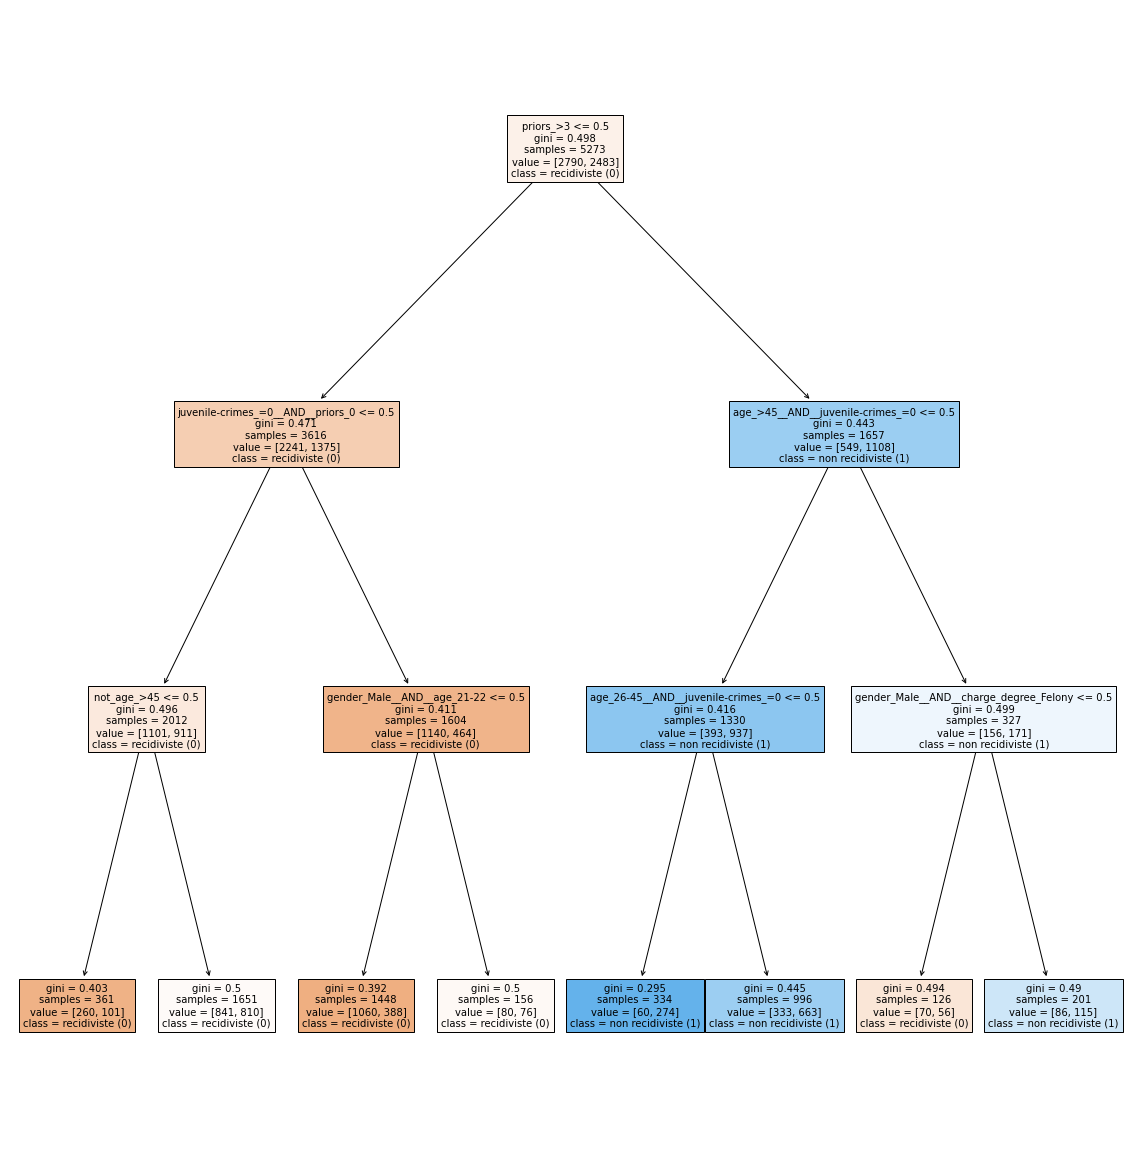

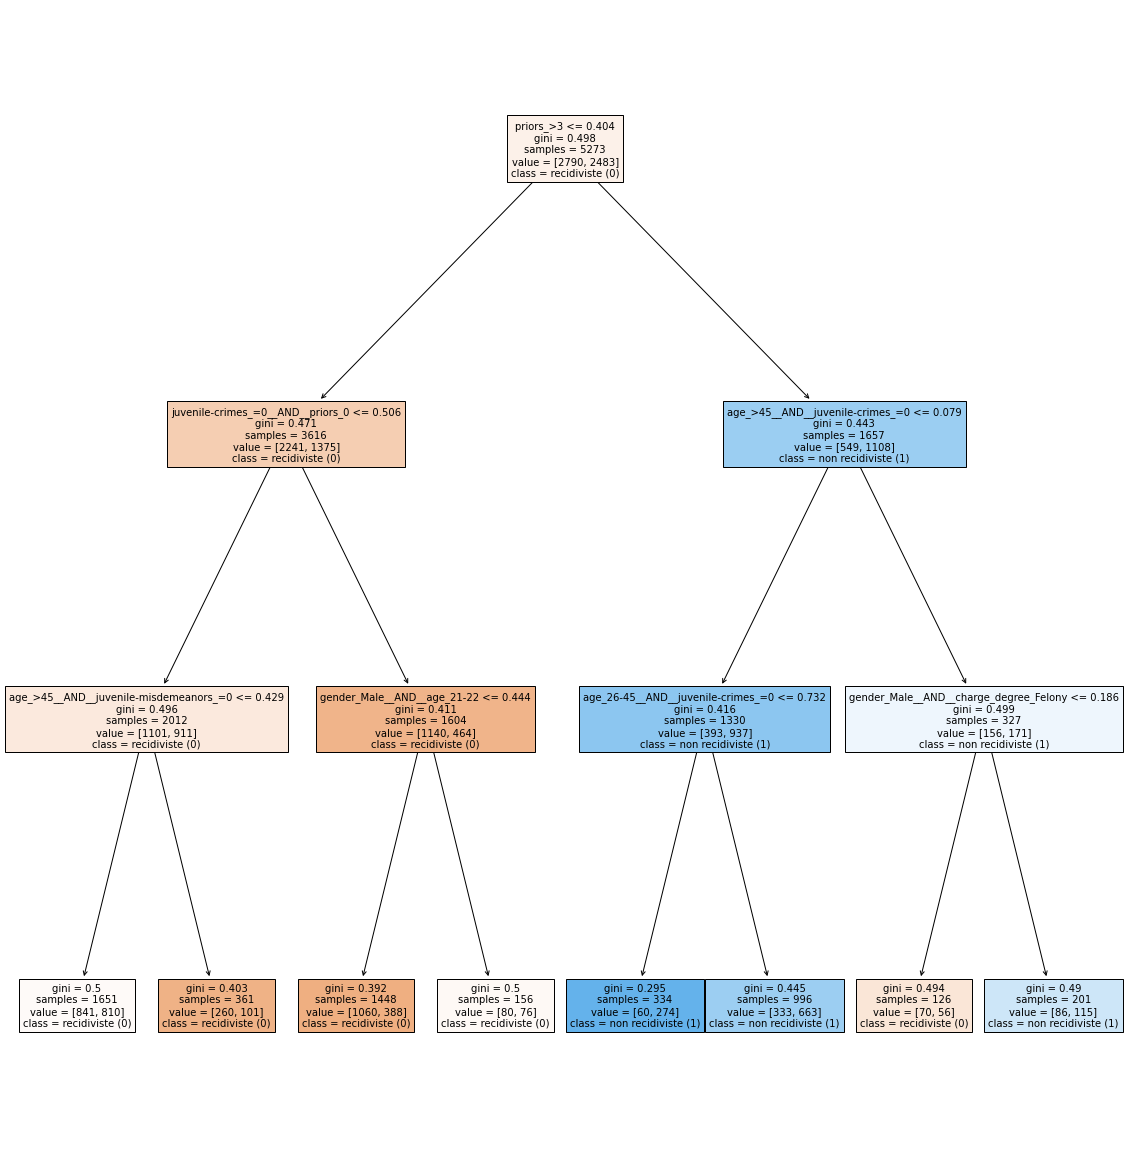

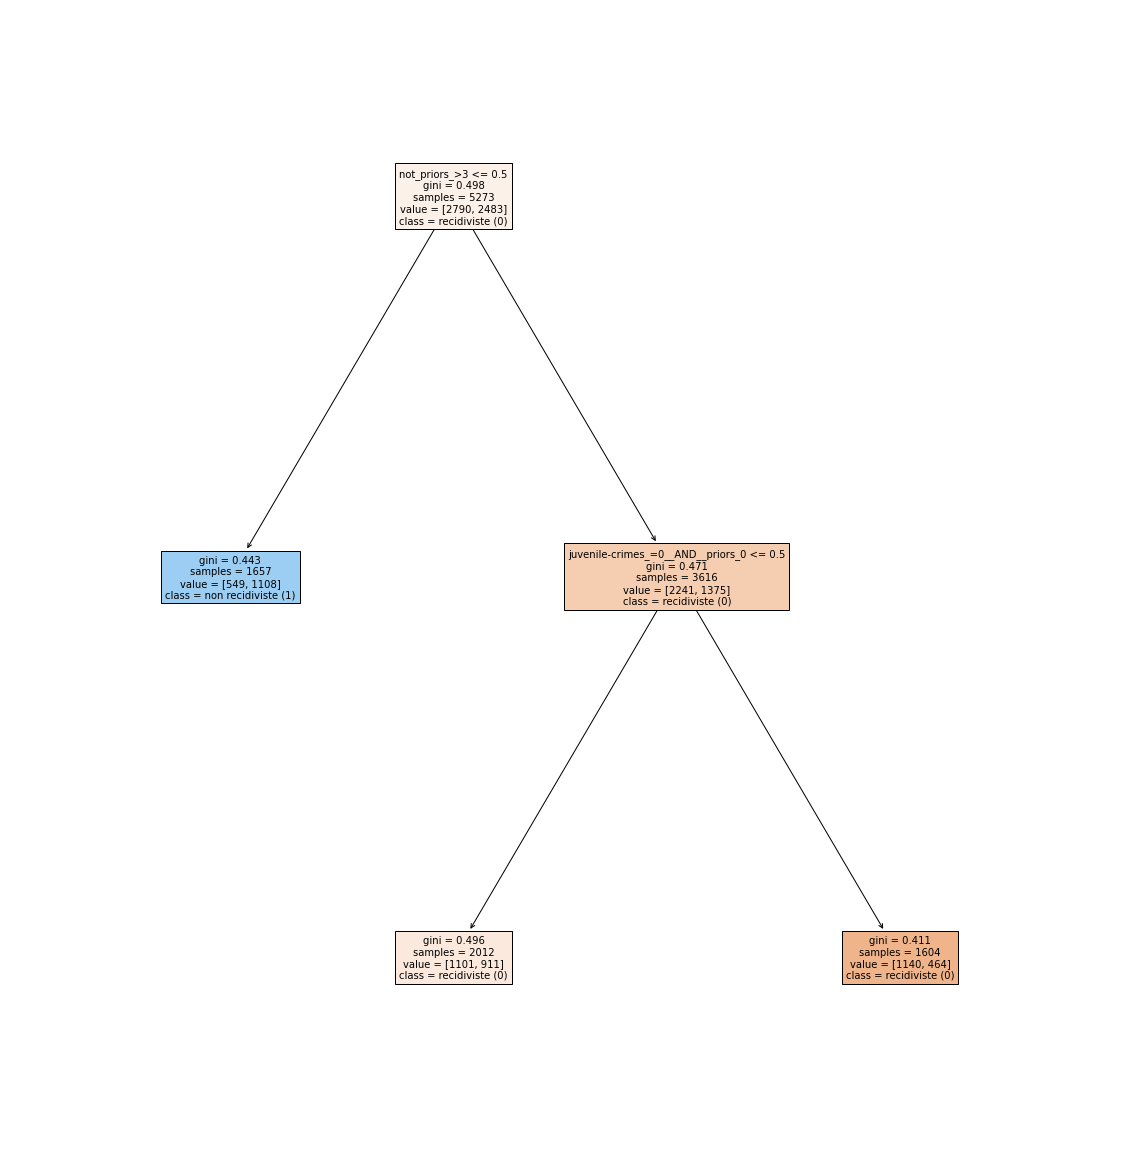

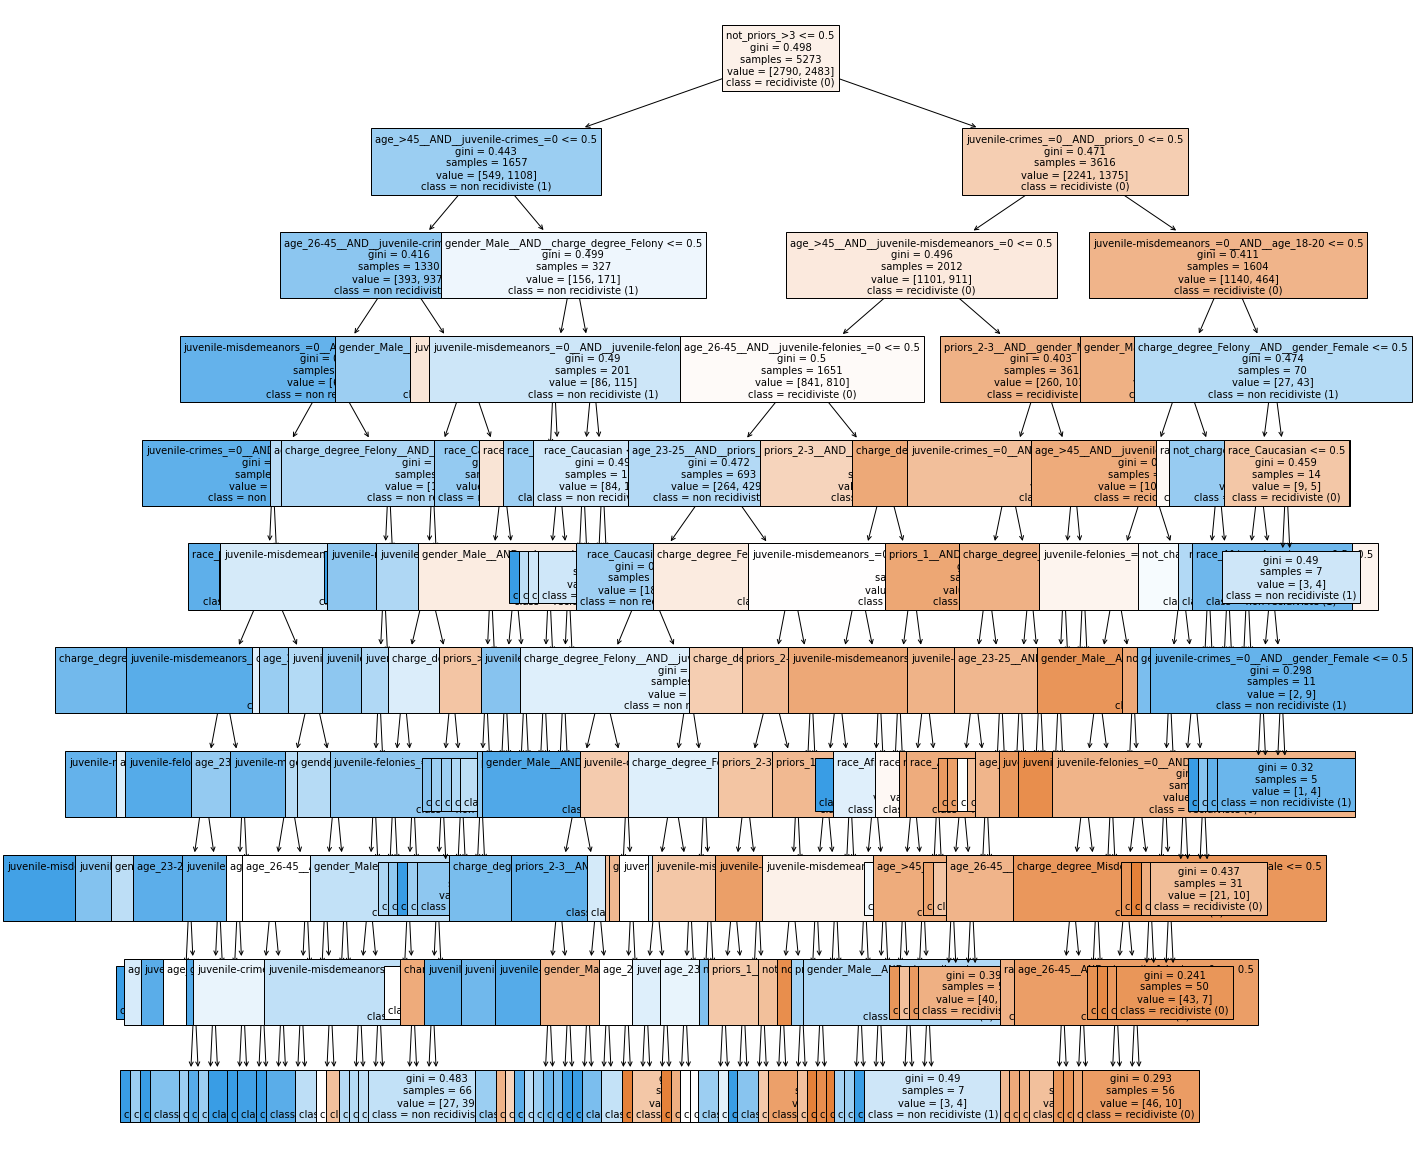

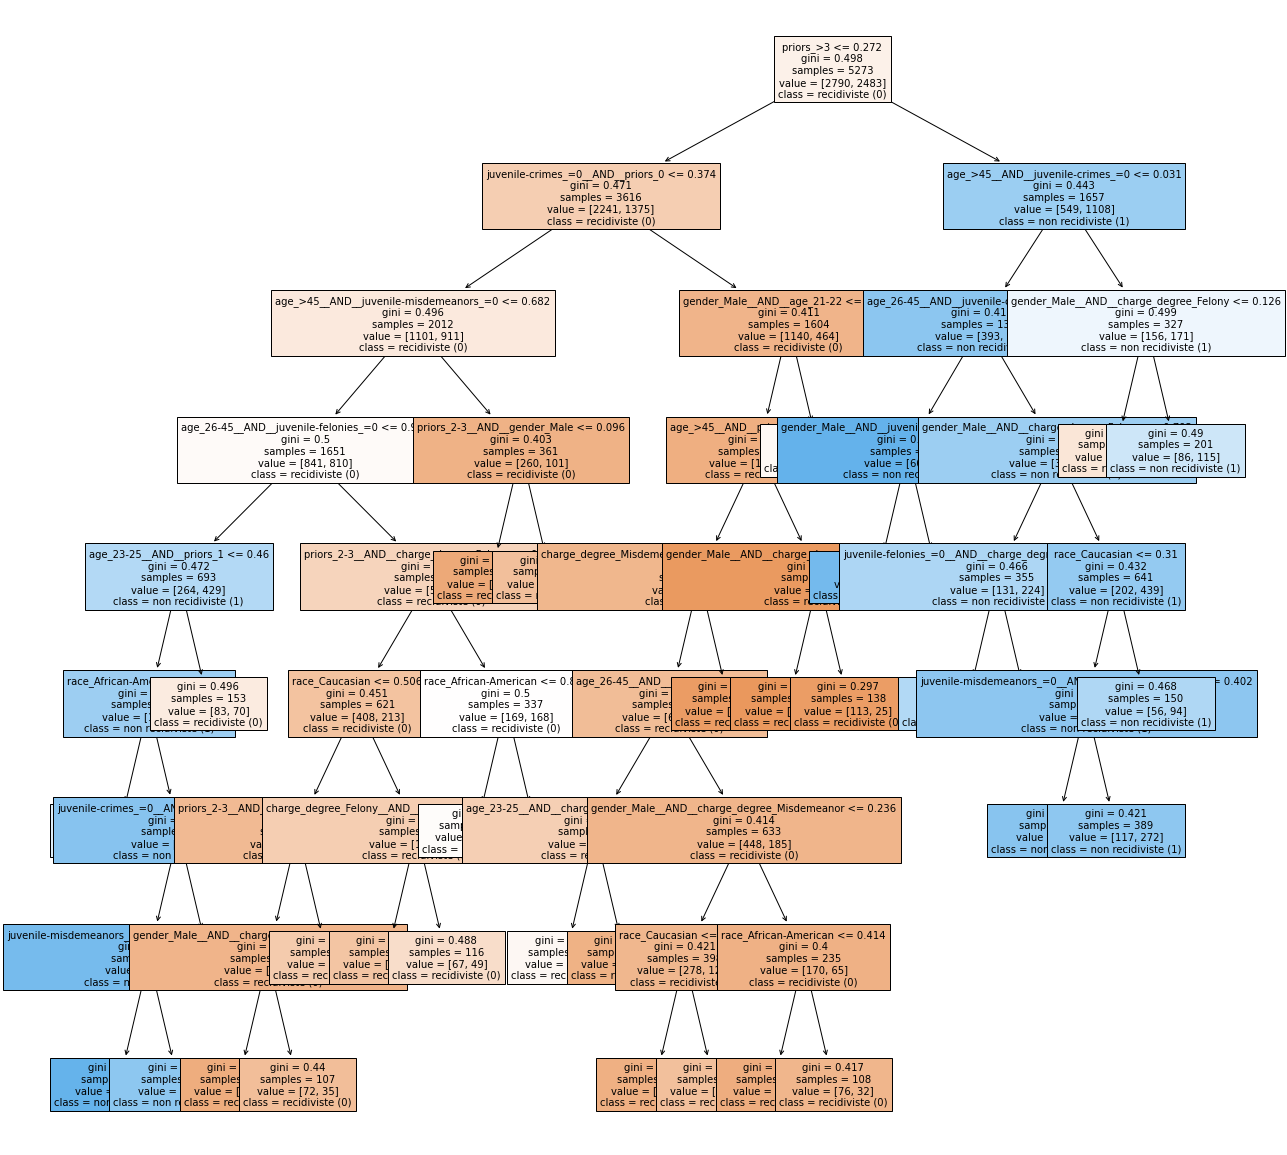

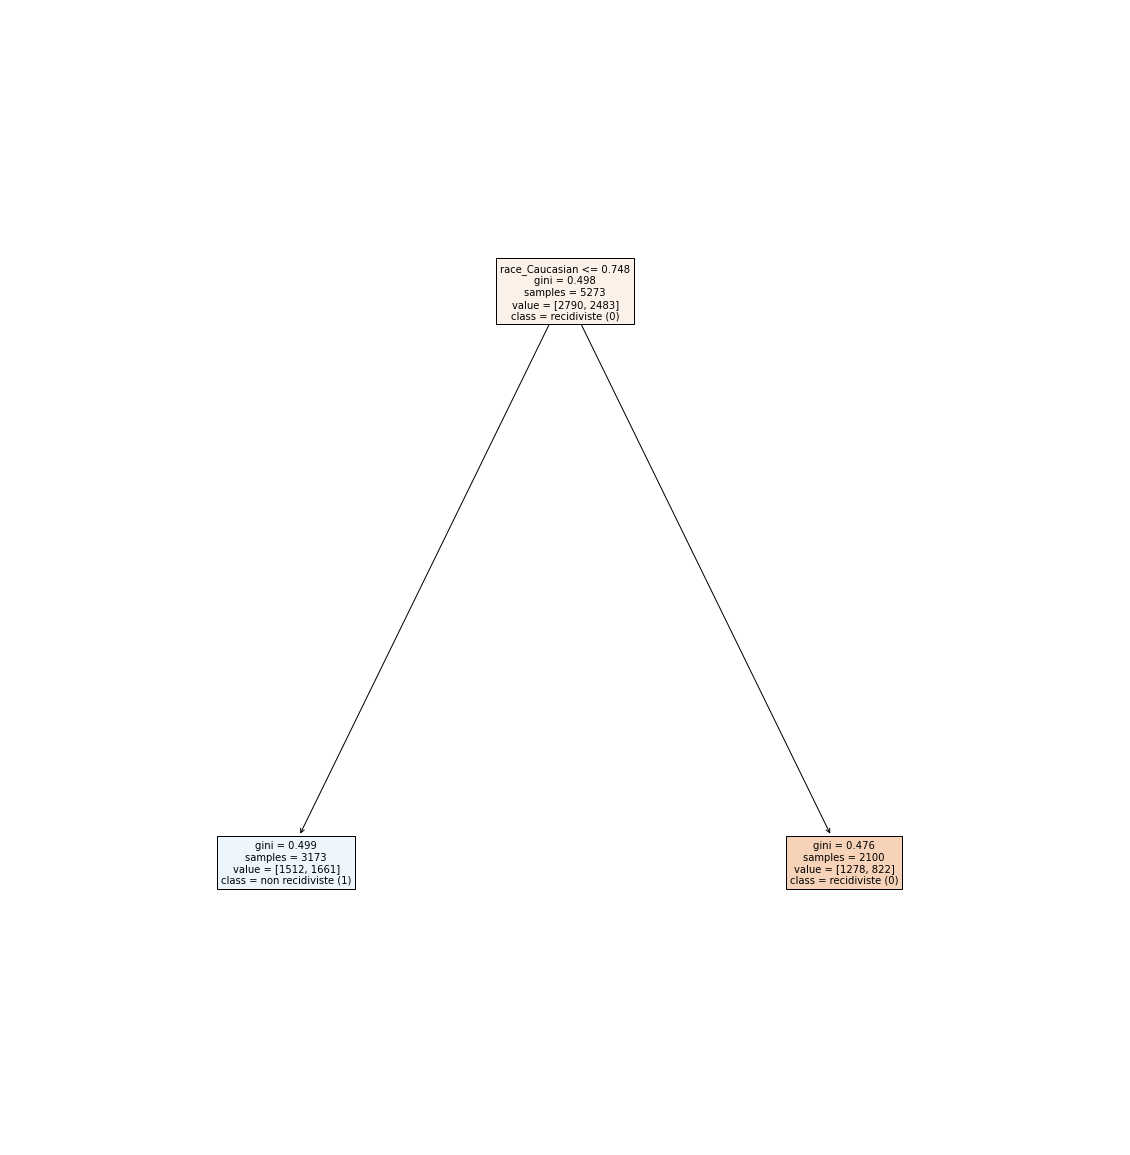

In [3]:
def createTree(train,trainl,conf): #create and train a tree with the train dataset and their labels trainl. 
                                    #conf is the configuration used to make the tree
    clf = tree.DecisionTreeClassifier(**conf)
    clf = clf.fit(train, trainl)
    return clf

def showTree(clf):
    fig = plt.figure(figsize=(20,21))
    _ = tree.plot_tree(clf, 
                       feature_names= features,
                       class_names= ("recidiviste (0)", "non recidiviste (1)" ), 
                       filled=True,
                       fontsize=10)

clf1 = createTree(train_examples,train_labels,conf1)
clf2 = createTree(train_examples,train_labels,conf2)
clf3 = createTree(train_examples,train_labels,conf3)
clf4 = createTree(train_examples,train_labels,conf4)
clf5 = createTree(train_examples,train_labels,conf5)
clf6 = createTree(train_examples,train_labels,conf6)

showTree(clf1)
showTree(clf2)
showTree(clf3)
showTree(clf4)
showTree(clf5)
showTree(clf6)

Propose an evaluation in terms of training and testing accuracies using $5$-cross validation on two decision trees that have different typologies

In [4]:
# Split dataset into training and test set
from sklearn.model_selection import train_test_split

def split_folds(examples,labels,Nfolds=5): 
    #Based on the dataset examples and their labels labels, this function returns Nfolds folds of the data and their labels
    length = int(len(examples)/Nfolds) #length of each fold
    folds = []
    foldsl = []
    for i in range(Nfolds-1):
        folds += [examples[i*length:(i+1)*length]]
        foldsl += [labels[i*length:(i+1)*length]]
    folds += [examples[(Nfolds-1)*length:len(examples)]]
    foldsl += [labels[(Nfolds-1)*length:len(labels)]]
    return folds,foldsl

def evaluateTree(clf,test,testl):
    
    #This funtion returns the confusion matrix of a trained tree.
    #The matrix is based on the dataset test and their labels testl
    
    res = clf.predict(test)
    
    confmatrix = np.zeros((2,2))
    
    for prediction,real in zip(res,testl):
        
        if real == 1:
            if prediction == 1:
                confmatrix[0,0]+=1
            if prediction == 0:
                confmatrix[0,1]+=1
        if real == 0:
            if prediction == 1:
                confmatrix[1,0]+=1
            if prediction == 0:
                confmatrix[1,1]+=1
    
    return confmatrix

def fivecross(conf,examples=train_examples,label=train_labels):
    
    #Given a configuration conf, this function make a 5-cross validation on the dataset examples split in 5 folds
    #It starts by training a tree on the full dataset except one fold that will be used that one to evaluate 
    #the tree (by making a confusion matrix)
    #It returns a final confusion matrix corresponding to the mean of the 5 confusion matrix of each tree.
    
    folds,foldsl = split_folds(examples,label)
    confmatrix = np.zeros((2,2))
    for i in range(5):
        if i != 4:
            train = [j for k in (folds[:i] + folds[i+1:]) for j in k]
            trainl = [j for k in (foldsl[:i] + foldsl[i+1:]) for j in k]
        else:
            train = [j for k in folds[:i] for j in k]
            trainl = [j for k in foldsl[:i] for j in k]
        test = folds[i]
        testl = foldsl[i]
        
        clf = createTree(train,trainl,conf)
        confmatrix = confmatrix + evaluateTree(clf,test,testl)
    
    confmatrix = confmatrix/5 ######################on est sensé prendre le meilleur non ?################
    
    return confmatrix

def evaluateConfMatrix(confmatrix):
    #This function computes the True Positive, False Postitive, True Negative and False Negative Rates
    #given a confusion matrix
    
    TP = 100*confmatrix[0,0]/(confmatrix[0,0]+confmatrix[0,1])
    TN = 100*confmatrix[1,1]/(confmatrix[1,0]+confmatrix[1,1])
    FP = 100- TP
    FN = 100 - TN
    return (TP,FP,TN,FN)

def showRates(rates): 
    #This function is used to print the rates given by the function evaluateConfMatrix
    
    print("True postive rate : "+str(round(rates[0],2))+"%")
    print("False postive rate : "+str(round(rates[1],2))+"%")
    print("True Negative rate : "+str(round(rates[2],2))+"%")
    print("False Negative rate : "+str(round(rates[3],2))+"%")
    

print("configuration : " + str(conf1))
showRates(evaluateConfMatrix(fivecross(conf1)))

print("\nconfiguration : " + str(conf5))
showRates(evaluateConfMatrix(fivecross(conf5)))


    
            
    


configuration : {'splitter': 'best', 'max_depth': 3, 'min_samples_leaf': 100}
True postive rate : 46.03%
False postive rate : 53.97%
True Negative rate : 79.1%
False Negative rate : 20.9%

configuration : {'splitter': 'random', 'max_depth': 10, 'min_samples_leaf': 100}
True postive rate : 60.53%
False postive rate : 39.47%
True Negative rate : 71.18%
False Negative rate : 28.82%


Propose an experimental study that shows the transition phase from underfitting to overfitting 

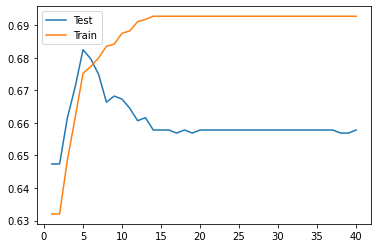

In [4]:
def accuracyConfusionMatrix(matrix):
    #Returns the rate of well predicted individuals based on a confusion matrix
    return (matrix[0,0] + matrix[1,1])/(matrix[0,0]+matrix[0,1]+matrix[1,0]+matrix[1,1])

def evaluateConfigurationAccuracy(conf,rstate=1,testsplit=0.2,
                                  example=train_examples,
                                  label=train_labels):
    #Given a configuration conf, this function train a tree on a random part of the dataset examples with the rest (testsplit) 
    #reserved for testing. Its returns the accuracy of the predictions on the training set and the testing set.
    
    train,test,trainl,testl = train_test_split(example, label,random_state=rstate, test_size = testsplit) 
    
    clf = createTree(train,trainl,conf) #training a tree
    
    matrixTest = evaluateTree(clf,test,testl) # to get the accuracy on the testing set
    matrixTrain = evaluateTree(clf,train,trainl) # to get the accuracy on the training set
    
    return accuracyConfusionMatrix(matrixTest),accuracyConfusionMatrix(matrixTrain)

# Experimental Study
#To show the transition phase between underfitting and overfitting, we took a simple configuration with a constant 
#splitter and min_samples_leaf and we increase the maximum depth of the tree from 1 to 40. 
#A tree with a small depth underfits while a more complex tree will tend to overfit

X = [i for i in range(1,41)] #our maximum depths
Y = [evaluateConfigurationAccuracy({"splitter" : "best", "max_depth" : i, "min_samples_leaf" : 1}) for i in range(1,41)]  #Accuracies rates of the testing and the training sets
Y1 = [E[0] for E in Y] # Accuracies of the testing set
Y2 = [E[1] for E in Y] # Accuracies of the training set


plt.plot(X, Y1, label='Test')
plt.plot(X, Y2, label='Train')
plt.legend()
plt.show()
plt.close()
    

We can see some underfitting with tree depths lower that 5, between 5 and 7 we have the transition phase (good part) and we have a little bit of overfitting with tree depth higher that 7. 
With the given dataset, we cannot have full overfitting (100% accuracy on the training set) and with maximum depths higher that 15, the accuracy of the training set is constant. As we randomly choose the testing set at each iteration, we have little variations of the the accuracy of the testing set.

Construct the confusion matrix on a particular good configuration (after explaining your choice)

In [5]:
#A good configuration have a good accuracy on both the training and the testing set.
#With our experiment, we decided to choose a maximum depth of 5, because it has a good 
#accuracy on the training set and the best recorded accuracy for the testing set.
good_conf = {"splitter" : "random", "max_depth" : 5, "min_samples_leaf" : 1}
train,test,trainl,testl = train_test_split(train_examples, train_labels,random_state=1, test_size = 0.2)
goodtree= createTree(train,trainl,good_conf)    

confusion_good_conf = evaluateTree(goodtree,train_examples, train_labels) #this is the confusion matrix made with the entire dataset
print(accuracyConfusionMatrix(confusion_good_conf))
print("This the confusion matrix of a good configuration : \n" + str(confusion_good_conf))


0.6766546557936658
This the confusion matrix of a good configuration : 
[[1416. 1067.]
 [ 638. 2152.]]


Provide an evaluation of the fairness of the model based on the False Positive Rate

In [6]:
good_rates = evaluateConfMatrix(confusion_good_conf)
showRates(good_rates)


True postive rate : 57.03%
False postive rate : 42.97%
True Negative rate : 77.13%
False Negative rate : 22.87%


Based on the rates given by this confusion matrix, we can see that a bit less than half of the positive individuals were predicted negative. This shows that this model is negatively biased towards the real positive individuals, missing almost half of them.